## IMPORT LIBRARY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,Callback
from sklearn.utils import class_weight
import tensorflow as tf
import tensorflowjs as tfjs
from keras.layers import TFSMLayer
from keras import Input, Model
from google.colab import drive

## DATA LOADING

In [ ]:
# Path dataset asli dan target output split (di dalam Google Drive)
original_dataset_path = "/content/drive/MyDrive/materi/Laporan magang /Dataset"

# Folder target untuk menyimpan dataset yang sudah diresize
target_base_dir = "/content/data_split"

In [ ]:
# Kelas yang akan digunakan
selected_classes = ['Sampah Organik Basah (LAYAK KOMPOS)','Sampah Organik Kering (LAYAK KOMPOS)','Sampah Tidak Layak Kompos']

In [ ]:
image_counts = {}
widths = []
heights = []

for cls in selected_classes:
    class_path = os.path.join(original_dataset_path, cls)
    image_list = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_counts[cls] = len(image_list)

    for img_name in image_list:
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                widths.append(img.size[0])
                heights.append(img.size[1])
        except:
            continue

In [ ]:
for cls, count in image_counts.items():
    print(f"{cls}: {count} gambar")

Sampah Organik Basah (LAYAK KOMPOS): 4451 gambar
Sampah Organik Kering (LAYAK KOMPOS): 4009 gambar
Sampah Tidak Layak Kompos: 4004 gambar


In [ ]:
# Statistik ukuran
print(f"Rata-rata ukuran gambar: {np.mean(widths):.2f} x {np.mean(heights):.2f}")
print(f"Ukuran minimum: {min(widths)} x {min(heights)}")
print(f"Ukuran maksimum: {max(widths)} x {max(heights)}")

Rata-rata ukuran gambar: 850.39 x 774.99
Ukuran minimum: 80 x 95
Ukuran maksimum: 5472 x 4160


In [ ]:
# Parameter gambar dan training
img_size = (512, 512)  # Ukuran gambar setelah resize
batch_size = 16
num_classes = len(selected_classes)

## DATA SPLITING

In [ ]:
# Buat folder train/val/test
for split in ['train', 'val', 'test']:
    for cls in selected_classes:
        os.makedirs(os.path.join(target_base_dir, split, cls), exist_ok=True)

# Proses tiap kelas
for cls in selected_classes:
    cls_folder = os.path.join(original_dataset_path, cls)
    images = [img for img in os.listdir(cls_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Split data
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    def process_and_save(images_list, split_type):
        for img_name in images_list:
            src = os.path.join(cls_folder, img_name)
            dst = os.path.join(target_base_dir, split_type, cls, img_name)
            try:
                # Resize dan simpan ulang
                with Image.open(src) as img:
                    img = img.convert("RGB")  # Jaga agar konsisten channel
                    img = img.resize(img_size)
                    img.save(dst)
            except Exception as e:
                print(f"Error processing {src}: {e}")

    # Simpan semua hasil resize ke folder target
    process_and_save(train_imgs, 'train')
    process_and_save(val_imgs, 'val')
    process_and_save(test_imgs, 'test')

print(" Dataset sudah diresize dan dipisahkan ke train/val/test.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing /content/drive/MyDrive/materi/Laporan magang /Dataset/Sampah Organik Kering (LAYAK KOMPOS)/ranting_328.jpg: cannot identify image file '/content/drive/MyDrive/materi/Laporan magang /Dataset/Sampah Organik Kering (LAYAK KOMPOS)/ranting_328.jpg'
Error processing /content/drive/MyDrive/materi/Laporan magang /Dataset/Sampah Organik Kering (LAYAK KOMPOS)/roti_207.jpg: cannot identify image file '/content/drive/MyDrive/materi/Laporan magang /Dataset/Sampah Organik Kering (LAYAK KOMPOS)/roti_207.jpg'
 Dataset sudah diresize dan dipisahkan ke train/val/test.


## MOBILENETV2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Parameter

In [ ]:
img_size = (512, 512)
batch = 16
num_classes = 3
dataset_dir = "/content/data_split"

### Data Generator

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/train",
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/val",
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/test",
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch
)

Found 9968 files belonging to 3 classes.
Found 1246 files belonging to 3 classes.
Found 1248 files belonging to 3 classes.


### Preprocessing

In [ ]:
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
from enum import auto
autotune = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=autotune)
val_data = val_data.prefetch(buffer_size=autotune)
test_data = test_data.prefetch(buffer_size=autotune)

## BASE MODEL

In [ ]:
img_shape = img_size + (3,)
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False

<ipython-input-16-c07971442949>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ==== BASE MODEL ====
IMG_SHAPE = img_size + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False  # awalnya freeze dulu

# ==== FULL MODEL ====
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-18-5e2481b31180>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [ ]:
class Stopdiakurasi(tf.keras.callbacks.Callback):
  def __init__(self, acc_threshold=0.95):
      super().__init__()
      self.acc_threshold = acc_threshold

  def on_epoch_end(self, epoch, logs= None):
    acc = logs.get("accuracy")
    val_acc = logs.get("val_accuracy")
    if acc is not None and val_acc is not None:
      if acc >= self.acc_threshold and val_acc >= self.acc_threshold:
        print(f"Target tercapa! akurasi dan val_akurasi > {self.acc_threshold*100:.0f}%. Stop training.")
        self.model.stop_training = True

In [ ]:
callbacks = [
    Stopdiakurasi(acc_threshold=0.95),
    ReduceLROnPlateau(patience=3, factor=0.5),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


In [ ]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 10,
    callbacks = callbacks
)

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5019 - loss: 1.0245

623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.5021 - loss: 1.0242 - val_accuracy: 0.8579 - val_loss: 0.5459 - learning_rate: 1.0000e-04
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8439 - loss: 0.5024

623/623 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.8439 - loss: 0.5024 - val_accuracy: 0.8884 - val_loss: 0.3952 - learning_rate: 1.0000e-04
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8879 - loss: 0.3770

623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - accuracy: 0.8879 - loss: 0.3770 - val_accuracy: 0.9101 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9071 - loss: 0.3160

623/623 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - accuracy: 0.9071 - loss: 0.3160 - val_accuracy: 0.9238 - val_loss: 0.2804 - learning_rate: 1.0000e-04
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9155 - loss: 0.2761

623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - accuracy: 0.9155 - loss: 0.2761 - val_accuracy: 0.9302 - val_loss: 0.2505 - learning_rate: 1.0000e-04
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9264 - loss: 0.2447

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9264 - loss: 0.2447 - val_accuracy: 0.9398 - val_loss: 0.2284 - learning_rate: 1.0000e-04
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9348 - loss: 0.2233

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9348 - loss: 0.2233 - val_accuracy: 0.9470 - val_loss: 0.2116 - learning_rate: 1.0000e-04
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9359 - loss: 0.2074

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9359 - loss: 0.2074 - val_accuracy: 0.9478 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 9/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9412 - loss: 0.1947

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9412 - loss: 0.1947 - val_accuracy: 0.9518 - val_loss: 0.1874 - learning_rate: 1.0000e-04
Epoch 10/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9435 - loss: 0.1881

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9435 - loss: 0.1881 - val_accuracy: 0.9543 - val_loss: 0.1781 - learning_rate: 1.0000e-04


In [ ]:

# ==== EVALUASI ====
loss, acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {acc:.2%}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9623 - loss: 0.1525

Test Accuracy: 95.67%


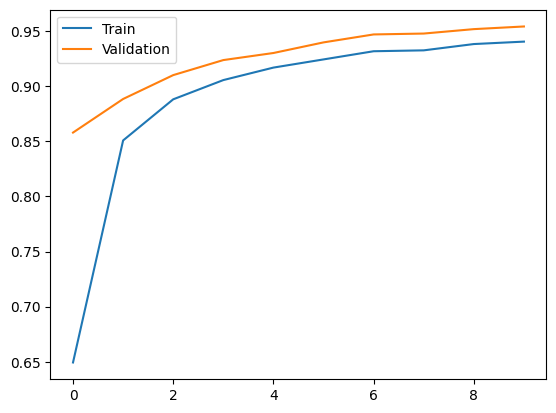

In [ ]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.legend()

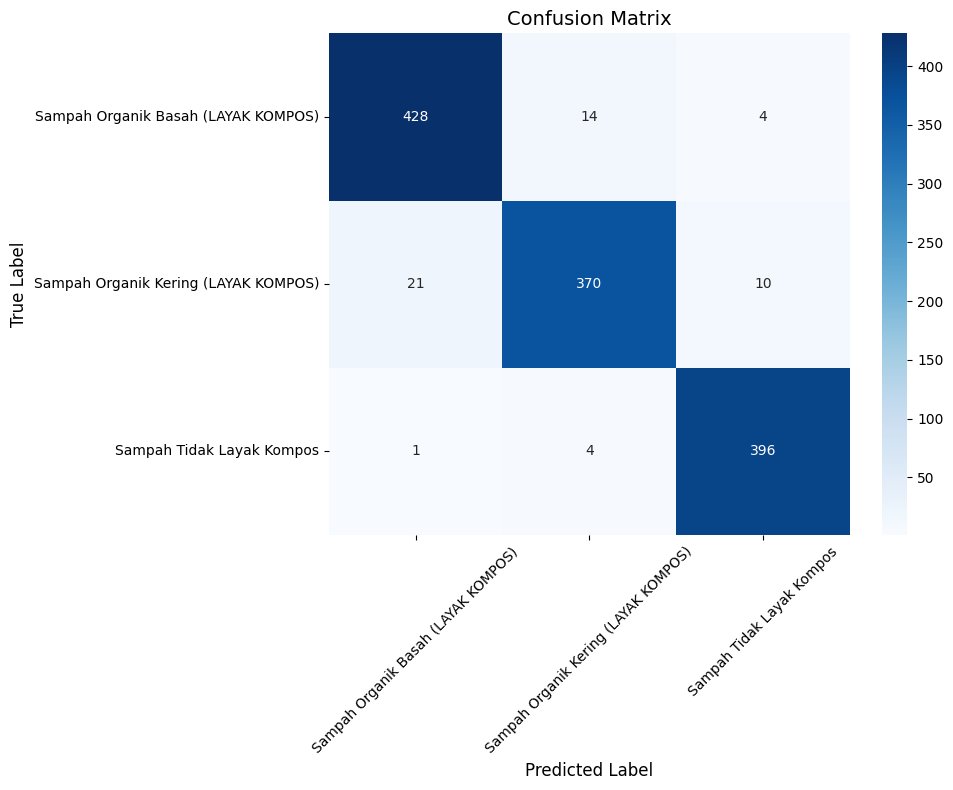


Classification Report:
                                      precision    recall  f1-score   support

 Sampah Organik Basah (LAYAK KOMPOS)       0.95      0.96      0.96       446
Sampah Organik Kering (LAYAK KOMPOS)       0.95      0.92      0.94       401
           Sampah Tidak Layak Kompos       0.97      0.99      0.98       401

                            accuracy                           0.96      1248
                           macro avg       0.96      0.96      0.96      1248
                        weighted avg       0.96      0.96      0.96      1248



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_data):
  y_ori = []
  y_pred = []

  class_names = sorted(['Sampah Organik Basah (LAYAK KOMPOS)',
                       'Sampah Organik Kering (LAYAK KOMPOS)',
                       'Sampah Tidak Layak Kompos'])
  for images, labels in test_data:
    y_ori.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

  cm = confusion_matrix(y_ori, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.title('Confusion Matrix', fontsize=14)
  plt.xlabel('Predicted Label', fontsize=12)
  plt.ylabel('True Label', fontsize=12)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

  print("\nClassification Report:")
  print(classification_report(y_ori, y_pred, target_names=class_names))

plot_confusion_matrix(model, test_data)

📤 Silakan upload gambar sampah untuk diprediksi:


Saving WhatsApp Image 2025-05-05 at 12.25.09_9c63aff5.jpg to WhatsApp Image 2025-05-05 at 12.25.09_9c63aff5.jpg


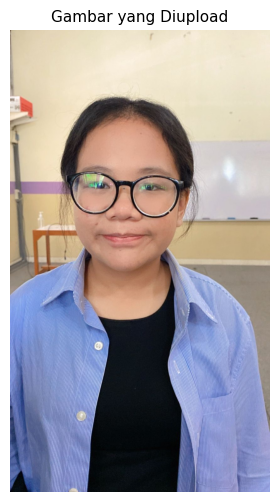

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

🔍 Hasil Prediksi:
♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️
➡ Sampah Tidak Layak Kompos
♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️

Keterangan:
- 'LAYAK KOMPOS' berarti sampah bisa diolah menjadi kompos 🗿
- 'Tidak Layak Kompos' berarti sampah harus dibuang ke tempat sampah umum 🥶


In [ ]:
from google.colab import files
from PIL import Image
import io

def upload_and_predict(model):
    # Upload gambar
    uploaded = files.upload()

    # Daftar kelas yang ada
    class_names = ['Sampah Organik Basah (LAYAK KOMPOS)',
                   'Sampah Organik Kering (LAYAK KOMPOS)',
                   'Sampah Tidak Layak Kompos']
    for namafile in uploaded.keys():
      try:
        img = Image.open(io.BytesIO(uploaded[namafile]))
        # Tampilkan gambar
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title("Gambar yang Diupload", fontsize=11)
        plt.axis('off')
        plt.show()

        # preprocess gambar
        img = img.convert('RGB').resize((512,512))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions)

        #MENAMPILKAN KELAS DENGAN PREDIKSI TERTINGGI
        print("\n🔍 Hasil Prediksi:")
        print("♣️"*15)
        print(f"➡ {class_names[predicted_class_idx]}")
        print("♣️"*15)
        print("\nKeterangan:")
        print("- 'LAYAK KOMPOS' berarti sampah bisa diolah menjadi kompos 🗿")
        print("- 'Tidak Layak Kompos' berarti sampah harus dibuang ke tempat sampah umum 🥶")
      except Exception as e:
        print(f"Error processing image: {e}")


# Jalankan fungsi
print("📤 Silakan upload gambar sampah untuk diprediksi:")
upload_and_predict(model)